#### Q1: Saturation timing
1. Forecast a central scenario for the network on the current trajectory. Define saturation threshold as when NetworkQAP becomes Yx greater than NetworkRBP, where Y is based on the terminal FIL+ rate.  What date is does this happen?
2. How does this date change across onboarding scenarios: RBPonboarding in {2,4,6,8,10}PiB/day and FIL+ rate in {50, 75, 100}%

#### Q2: Macro sunset
1. Compare three main macro scenarios: (i) no change (ii) FIL+ rate = 100% (iii) FIL+ rate = 0%. For scenarios (ii) and (iii) simulate the central scenario up to the saturation threshold, then introduce a change point in the FIL+ rate to simulate sunsetting.
2. For each of the two counterfactual sunset scenarios (ii) and (iii), show variations where the assumed raw-byte onboarding after the change is {5,10,15,20,25}PiB/day

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

from cel_utils import disk_utils

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/filp_saturation')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,28) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-25 2033-07-22


In [5]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

In [6]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics

In [7]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 2000
num_samples_mcmc = 2000
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [8]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)
day_vec = np.arange(0,len(hist_fpr))

In [9]:
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc)
    
    rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
    ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
    expire_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])
    
    print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
    print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
    print('Expirations Forecast RHat < 1.05: %0.02f %%' % (expire_rhat_check*100,))
    
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred':renewal_rate_pred,
        'historical_rb_date':historical_rb_date,
        'historical_rb':historical_rb,
        'historical_rr_date':historical_rr_date,
        'historical_rr':historical_rr,
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

Forecasting Onboarding Power


/Users/kiran/code/scenario-generator/scenario_generator/mcmc_forecast.py:131: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=num_chains_mcmc, progress_bar=verbose)


Forecasting Renewal Rate


/Users/kiran/code/scenario-generator/scenario_generator/mcmc_forecast.py:131: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=num_chains_mcmc, progress_bar=verbose)
/Users/kiran/code/scenario-generator/scenario_generator/mcmc_forecast.py:131: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n

RBP Forecast RHat < 1.05: 83.68 %
Extensions Forecast RHat < 1.05: 100.00 %
Expirations Forecast RHat < 1.05: 100.00 %


In [10]:
# logistic model for FPR forecast
def fpr_logistic_growth_model(x, y=None):
    # priors
    x0 = numpyro.sample("x0", dist.Normal(x.shape[0] // 2, 50)) # midpoint
    k = numpyro.sample("k", dist.Normal(0, 0.1)) # growth rate
    L = numpyro.sample("L", dist.Beta(1, 1)) # carrying capacity
    
    # logistic model
    filp = numpyro.deterministic("filp", L / (1 + jnp.exp(-k * (x - x0))))
    
    # Bernoulli likelihood version
    numpyro.sample(
        "obs",
        dist.Bernoulli(probs=filp),
        obs=y,
    )

In [11]:
def model_filp():
    filp_mcmc = MCMC(
        NUTS(fpr_logistic_growth_model, dense_mass=True),
        num_warmup=num_warmup_mcmc,
        num_samples=num_samples_mcmc,
        num_chains=num_chains_mcmc,
        progress_bar=True,
    )
    filp_mcmc.run(PRNGKey(1), x=day_vec, y=hist_fpr)
    filp_mcmc.print_summary()

    return {'filp_mcmc': filp_mcmc}

filp_data = model_filp()
locals().update(filp_data)

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_39972/3388844456.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  filp_mcmc = MCMC(
sample: 100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 3995.99it/s, 3 steps of size 4.12e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.90      0.05      0.90      0.83      1.00   2112.36      1.00
         k      0.02      0.00      0.01      0.01      0.02   3931.23      1.00
        x0    519.41     15.14    519.89    494.59    544.23   2251.85      1.00

Number of divergences: 0


In [12]:
predictive = Predictive(fpr_logistic_growth_model, filp_mcmc.get_samples())
preds = predictive(PRNGKey(1), x=day_vec)["obs"]

In [13]:
carrying_capacity = filp_mcmc.get_samples()['L']
print("Carrying capacity mean and [Q10,Q90]:")
mu_L, q10q90_L = jnp.median(carrying_capacity),  jnp.percentile(carrying_capacity,  jnp.array([10, 90]), 0)
mu_L, q10q90_L

Carrying capacity mean and [Q10,Q90]:


(Array(0.89890915, dtype=float32),
 Array([0.82540613, 0.96751463], dtype=float32))

<IPython.core.display.Javascript object>


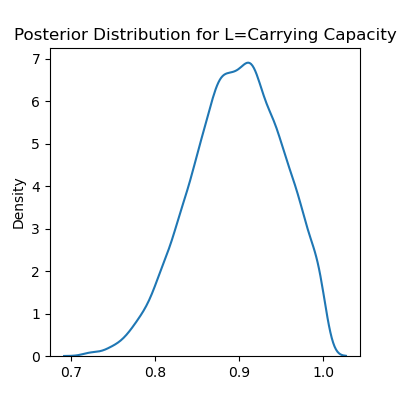

In [35]:
plt.figure(figsize=(4,4))
sns.kdeplot(carrying_capacity)
plt.title('Posterior Distribution for L=Carrying Capacity')
plt.savefig(os.path.join(save_dir, 'L_posterior.png'))

In [15]:
# for each trajectory, run mechaFIL and plot metrics: QAP/RBP
central_scenarios = []

lock_target = 0.3
sector_duration = 540

for ii in tqdm(range(num_chains_mcmc*num_samples_mcmc)):
    rbp = rb_onboard_power_pred[ii]
    rr = renewal_rate_pred[ii]
    L = carrying_capacity[ii]
    fpr = jnp.ones(forecast_length) * L

    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    central_scenarios.append(simulation_results)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [16]:
def compute_quantiles(results, keys=['network_RBP_EIB'], xform=None, q=[0.05, 0.25, 0.50, 0.75, 0.95]):
    key_vec = []
    for r in results:
        tmp_res = []
        for k in keys:
            tmp_res.append(r[k])
            
        if xform is None:
            key_vec.append(tmp_res[0])
        else:
            xx = xform(tmp_res)
            if xx is not None:
                key_vec.append(xx)
    key_vec = np.asarray(key_vec)
    return np.nanquantile(key_vec, q, axis=0)

In [17]:
t = du.get_t(start_date, end_date=end_date)

<IPython.core.display.Javascript object>


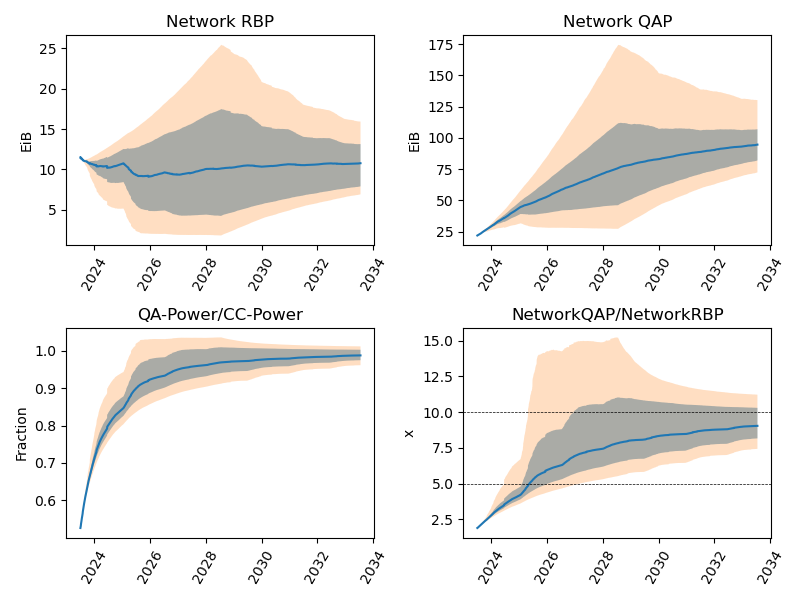

In [39]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB'])
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')

plt.subplot(2,2,2)
q = compute_quantiles(central_scenarios, keys=['network_QAP_EIB'])
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')

plt.subplot(2,2,3)
def deal_overall_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    
    # ignore sample if rbp --> 0
    th = 1
    if np.any(rbp <= th) or np.any(qap <= th):
        return None
    
    deal = (qap-rbp)/9.0
    cc = rbp - deal
    return (deal*10)/(cc+deal*10)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('QA-Power/CC-Power')
plt.ylabel('Fraction')

plt.subplot(2,2,4)
def qa_rb_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    return qap/rbp
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('NetworkQAP/NetworkRBP')
plt.ylabel('x')
plt.axhline(5, color='k', linestyle='--', linewidth=0.5)
plt.axhline(10, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'central_scenario_power.png'))

In [19]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

<IPython.core.display.Javascript object>


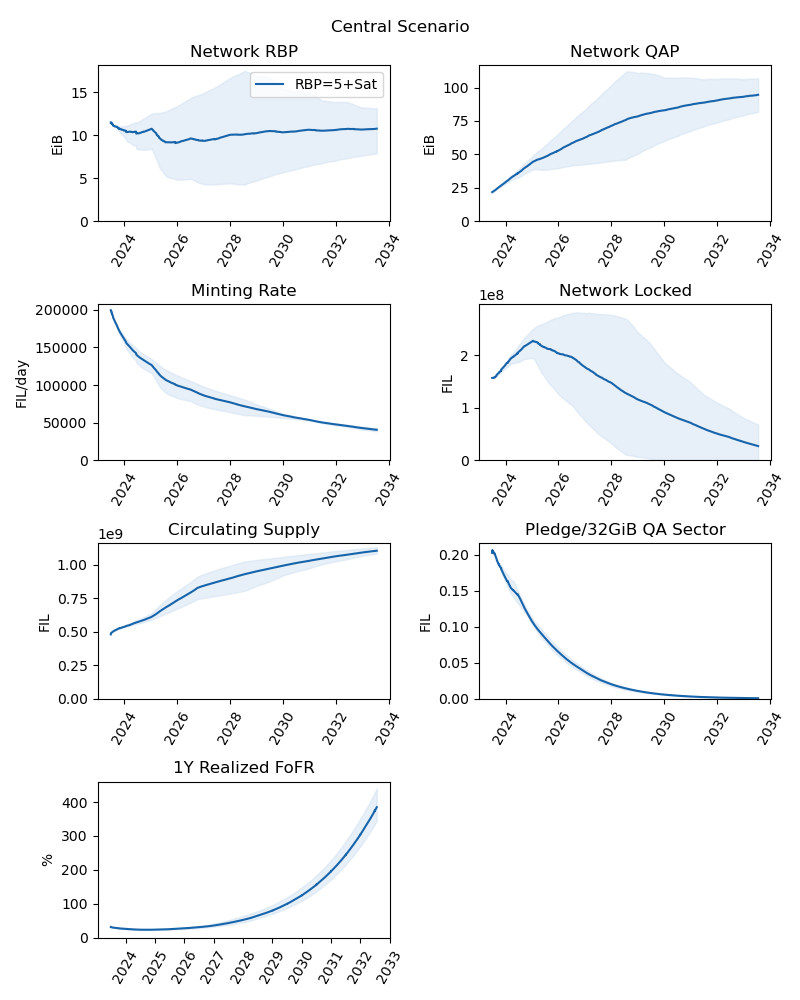

In [38]:
# plot KPIs

plt.figure(figsize=(8,10))

plt.subplot(4,2,1)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8), label='RBP=5+Sat')
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')
plt.ylim(0)
plt.legend()

plt.subplot(4,2,2)
q = compute_quantiles(central_scenarios, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')
plt.ylim(0)

plt.subplot(4,2,3)
q = compute_quantiles(central_scenarios, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')
plt.ylim(0)

plt.subplot(4,2,4)
q = compute_quantiles(central_scenarios, keys=['network_locked'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,5)
q = compute_quantiles(central_scenarios, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,6)
q = compute_quantiles(central_scenarios, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,7)
q = compute_quantiles(central_scenarios, keys=['1y_sector_roi'])
t_fofr = [start_date + timedelta(days=i) for i in range(len(q[2]))]
plt.plot(t_fofr, q[2]*100, color=colors[0](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('1Y Realized FoFR')
plt.ylabel('%')
plt.ylim(0)

plt.suptitle('Central Scenario')

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'central_scenario_kpi.png'))

In [21]:
# for each sample, compute the date at which QA/RB exceeds given threshold
def get_saturation_idx(result, thresh=10):
    qa_rb_ratio = result['network_QAP_EIB'] / result['network_RBP_EIB']
    x = np.where(qa_rb_ratio >= thresh)[0]
    if len(x) > 0:
        return x[0]
    else:
        return None

def get_saturation_dates(results, thresh=10):
    dates = []
    for r in results:
        date_idx = get_saturation_idx(r, thresh)
        if date_idx is not None:
            dates.append(t[date_idx])
    return dates

<IPython.core.display.Javascript object>


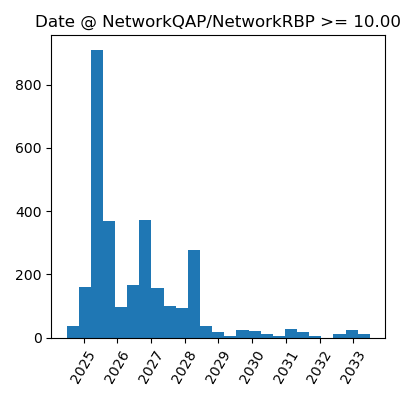

In [40]:
plt.figure(figsize=(4,4))
thresh=10
plt.hist(get_saturation_dates(central_scenarios, thresh=thresh), bins=25)
plt.xticks(rotation=60)
plt.title('Date @ NetworkQAP/NetworkRBP >= %0.02f' % (thresh,))
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'saturation_date.png'))

In [23]:
## Compute counterfactuals from central scenario once the saturation threshold is reached
qa_rb_threshold = 10
rbp_sweep_vec = [5, 10, 15, 20, 25]
filp_sweep_vec = [0, 1]

counterfactual_results = {}
for ii in tqdm(range(num_chains_mcmc*num_samples_mcmc)):
    # the original inputs which drove the central scenario
    rbp = rb_onboard_power_pred[ii]
    rr = renewal_rate_pred[ii]  # keep as is?
    L = carrying_capacity[ii]
    
    r = central_scenarios[ii]
    saturation_idx = get_saturation_idx(r, thresh=qa_rb_threshold)
    if saturation_idx is not None:
        # introduce change-points and rerun simulation
        for rbp_val in rbp_sweep_vec:
            for filp_val in filp_sweep_vec:
                rbp_counterfactual = jnp.copy(rbp)
                rbp_counterfactual = rbp_counterfactual.at[saturation_idx:].set(rbp_val)
                fpr_counterfactual = jnp.ones(forecast_length) * L
                fpr_counterfactual = fpr_counterfactual.at[saturation_idx:].set(filp_val)

                # rerun simulation
                simulation_results = sim.run_sim(
                    rbp_counterfactual,
                    rr,
                    fpr_counterfactual,
                    lock_target,

                    start_date,
                    current_date,
                    forecast_length,
                    sector_duration,
                    offline_data
                )

                key = (ii, rbp_val, filp_val)
                counterfactual_results[key] = simulation_results

  0%|          | 0/8000 [00:00<?, ?it/s]

In [24]:
def extract_results(res_dict, counterfactual_rbp=5, counterfactual_filp=1):
    mcmc_results = []
    for k, v in counterfactual_results.items():
        if k[1] == counterfactual_rbp and k[2] == counterfactual_filp:
            mcmc_results.append(v)
    return mcmc_results

In [25]:
cf_5_0 = extract_results(counterfactual_results, 5, 0)
cf_5_1 = extract_results(counterfactual_results, 5, 1)
cf_10_0 = extract_results(counterfactual_results, 10, 0)
cf_10_1 = extract_results(counterfactual_results, 10, 1)
cf_15_0 = extract_results(counterfactual_results, 15, 0)
cf_15_1 = extract_results(counterfactual_results, 15, 1)
cf_20_0 = extract_results(counterfactual_results, 20, 0)
cf_20_1 = extract_results(counterfactual_results, 20, 1)
cf_25_0 = extract_results(counterfactual_results, 25, 0)
cf_25_1 = extract_results(counterfactual_results, 25, 1)

print(len(cf_5_0), len(cf_5_1), 
     len(cf_10_0), len(cf_10_1), 
     len(cf_15_0), len(cf_15_1), 
     len(cf_20_0), len(cf_20_1), 
     len(cf_25_0), len(cf_25_1), )

2953 2953 2953 2953 2953 2953 2953 2953 2953 2953


<IPython.core.display.Javascript object>


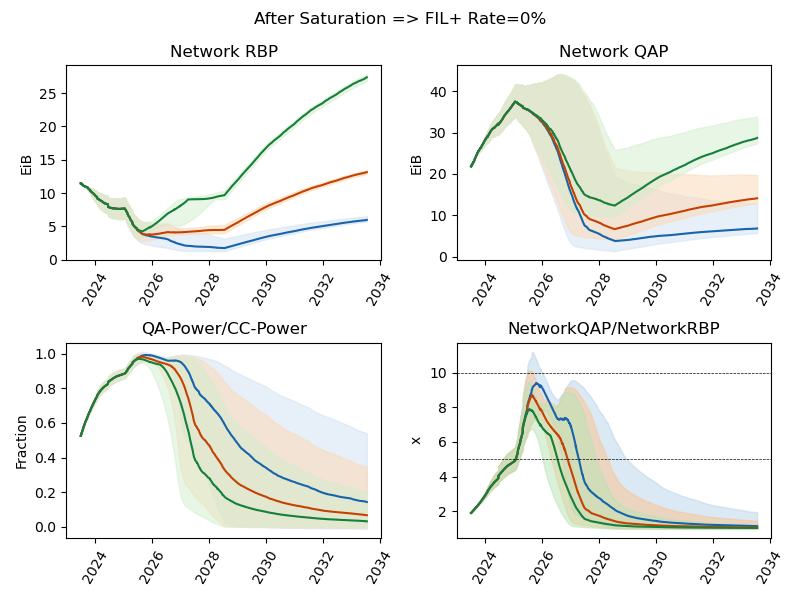

In [41]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
q = compute_quantiles(cf_5_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')

plt.subplot(2,2,2)
q = compute_quantiles(cf_5_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')

plt.subplot(2,2,3)
def deal_overall_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    
    # ignore sample if rbp --> 0
    th = 1
    if np.any(rbp <= th) or np.any(qap <= th):
        return None
    
    deal = (qap-rbp)/9.0
    cc = rbp - deal
    return (deal*10)/(cc+deal*10)
q = compute_quantiles(cf_5_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('QA-Power/CC-Power')
plt.ylabel('Fraction')

plt.subplot(2,2,4)
def qa_rb_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    return qap/rbp
q = compute_quantiles(cf_5_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.3), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.3), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.3), alpha=0.5)

plt.xticks(rotation=60)
plt.title('NetworkQAP/NetworkRBP')
plt.ylabel('x')
plt.axhline(5, color='k', linestyle='--', linewidth=0.5)
plt.axhline(10, color='k', linestyle='--', linewidth=0.5)

plt.suptitle('After Saturation => FIL+ Rate=0%')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'post_saturation_fpr0_power.png'))

<IPython.core.display.Javascript object>


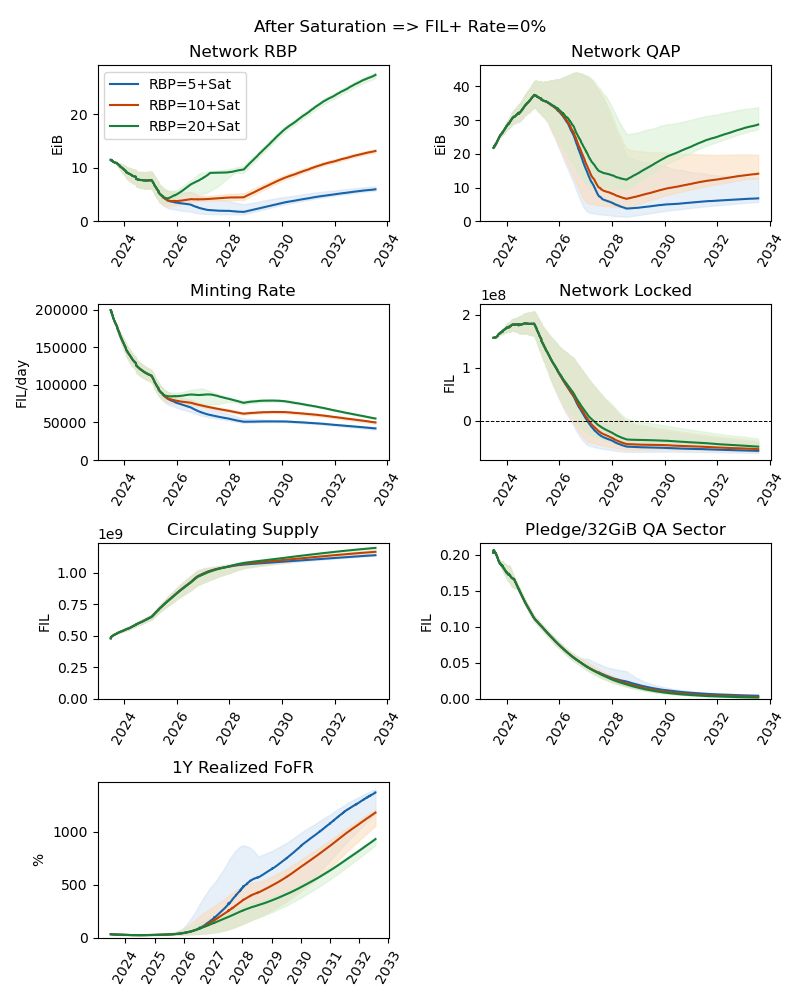

In [42]:
# plot KPIs

plt.figure(figsize=(8,10))

plt.subplot(4,2,1)
q = compute_quantiles(cf_5_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8), label='RBP=5+Sat')
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8), label='RBP=10+Sat')
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8), label='RBP=20+Sat')
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')
plt.ylim(0)
plt.legend()

plt.subplot(4,2,2)
q = compute_quantiles(cf_5_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')
plt.ylim(0)

plt.subplot(4,2,3)
q = compute_quantiles(cf_5_0, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')
plt.ylim(0)

plt.subplot(4,2,4)
q = compute_quantiles(cf_5_0, keys=['network_locked'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_locked'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_locked'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('FIL')
# plt.ylim(0)
plt.axhline(0, color='k', linestyle='--', linewidth=0.7)

plt.subplot(4,2,5)
q = compute_quantiles(cf_5_0, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,6)
q = compute_quantiles(cf_5_0, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,7)
q = compute_quantiles(cf_5_0, keys=['1y_sector_roi'])
t_fofr = [start_date + timedelta(days=i) for i in range(len(q[2]))]
plt.plot(t_fofr, q[2]*100, color=colors[0](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['1y_sector_roi'])
plt.plot(t_fofr, q[2]*100, color=colors[1](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['1y_sector_roi'])
plt.plot(t_fofr, q[2]*100, color=colors[2](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('1Y Realized FoFR')
plt.ylabel('%')
plt.ylim(0)

plt.suptitle('After Saturation => FIL+ Rate=0%')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'post_saturation_fpr0_kpi.png'))

<IPython.core.display.Javascript object>


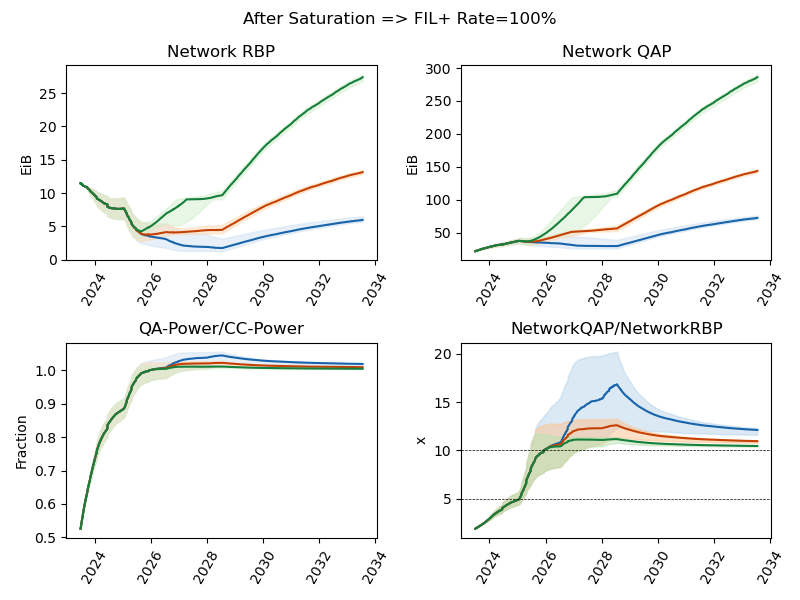

In [43]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
q = compute_quantiles(cf_5_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')

plt.subplot(2,2,2)
q = compute_quantiles(cf_5_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')

plt.subplot(2,2,3)
def deal_overall_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    
    # ignore sample if rbp --> 0
    th = 1
    if np.any(rbp <= th) or np.any(qap <= th):
        return None
    
    deal = (qap-rbp)/9.0
    cc = rbp - deal
    return (deal*10)/(cc+deal*10)
q = compute_quantiles(cf_5_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('QA-Power/CC-Power')
plt.ylabel('Fraction')

plt.subplot(2,2,4)
def qa_rb_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    return qap/rbp
q = compute_quantiles(cf_5_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.3), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.3), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.3), alpha=0.5)

plt.xticks(rotation=60)
plt.title('NetworkQAP/NetworkRBP')
plt.ylabel('x')
plt.axhline(5, color='k', linestyle='--', linewidth=0.5)
plt.axhline(10, color='k', linestyle='--', linewidth=0.5)

plt.suptitle('After Saturation => FIL+ Rate=100%')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'post_saturation_fpr100_power.png'))

<IPython.core.display.Javascript object>


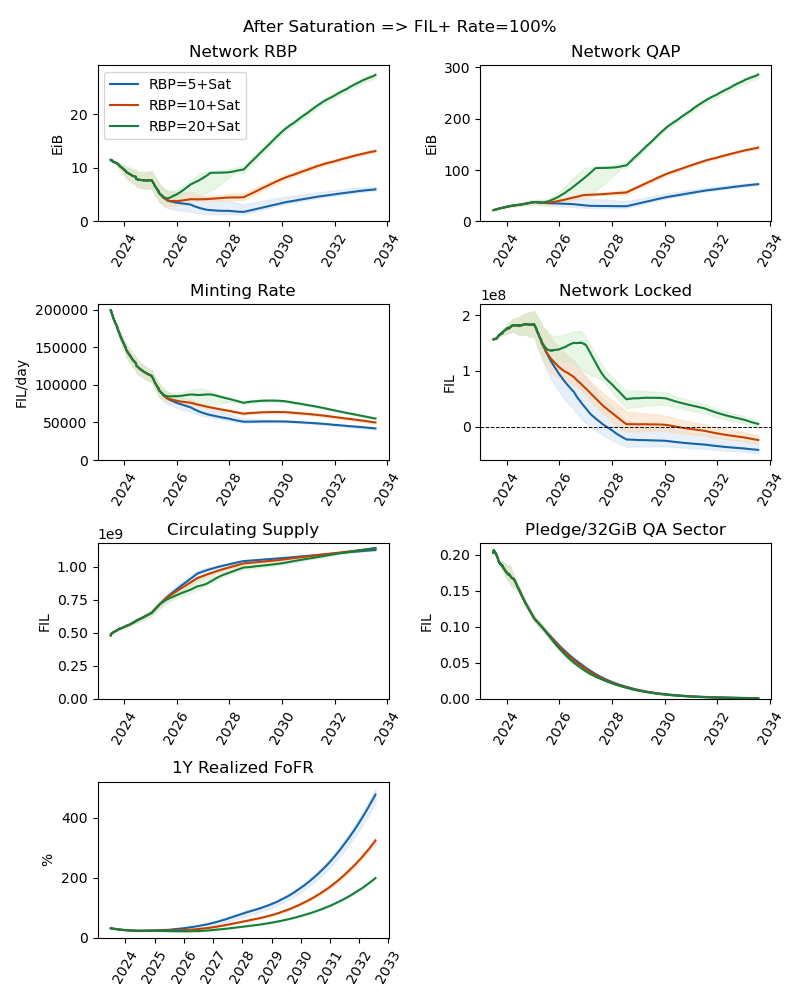

In [44]:
# plot KPIs

plt.figure(figsize=(8,10))

plt.subplot(4,2,1)
q = compute_quantiles(cf_5_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8), label='RBP=5+Sat')
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8), label='RBP=10+Sat')
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8), label='RBP=20+Sat')
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')
plt.ylim(0)
plt.legend()

plt.subplot(4,2,2)
q = compute_quantiles(cf_5_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')
plt.ylim(0)

plt.subplot(4,2,3)
q = compute_quantiles(cf_5_1, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')
plt.ylim(0)

plt.subplot(4,2,4)
q = compute_quantiles(cf_5_1, keys=['network_locked'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_locked'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_locked'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('FIL')
# plt.ylim(0)
plt.axhline(0, color='k', linestyle='--', linewidth=0.7)

plt.subplot(4,2,5)
q = compute_quantiles(cf_5_1, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,6)
q = compute_quantiles(cf_5_1, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[1](0.8))
plt.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[2](0.8))
plt.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,7)
q = compute_quantiles(cf_5_1, keys=['1y_sector_roi'])
t_fofr = [start_date + timedelta(days=i) for i in range(len(q[2]))]
plt.plot(t_fofr, q[2]*100, color=colors[0](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['1y_sector_roi'])
plt.plot(t_fofr, q[2]*100, color=colors[1](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['1y_sector_roi'])
plt.plot(t_fofr, q[2]*100, color=colors[2](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('1Y Realized FoFR')
plt.ylabel('%')
plt.ylim(0)

plt.suptitle('After Saturation => FIL+ Rate=100%')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'post_saturation_fpr100_kpi.png'))